<a href="https://colab.research.google.com/github/MikeXL/brain/blob/master/iris_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu90/torch_nightly.html

Looking in links: https://download.pytorch.org/whl/nightly/cu90/torch_nightly.html


In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

In [0]:
from sklearn import datasets
wine = datasets.load_wine()
wine.feature_names

**!!** *normalize* the input

In [0]:
model = nn.Sequential(
  nn.Linear(13,24),
  nn.ReLU(),
  nn.Linear(24,12),
  nn.ReLU(),
  nn.Linear(12,3),
  nn.Softmax(1)
)

In [0]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [0]:
def score():
  model.eval()
  out=model(torch.from_numpy(wine.data).float())
  _, pred = torch.max(out, 1)

  print "Misclassified %s/%s" % ((y.size(0) - (pred.data==y.data).sum(0)), y.size(0))


In [0]:
x = torch.from_numpy(wine.data).float()
y = torch.from_numpy(wine.target).long()

In [0]:
epoch = 500
lr = .1

In [433]:
# train L-BFGS


optim = torch.optim.LBFGS(model.parameters(), lr=lr)

def fit_lbfgs():
  losses = []
  for _ in range(epoch):
    def closure():
      optim.zero_grad()
      yhat = model(x)
      loss = nn.CrossEntropyLoss()(yhat, y)
      losses.append(loss.item())
      loss.backward()
      return loss
    optim.step(closure)
  return losses

model.apply(weight_reset)
model.train()
loss_lbfgs = fit_lbfgs()
score()

Misclassified tensor(0)/178


In [434]:
optim_adam = torch.optim.Adam(model.parameters(), lr=lr)
optim_sgd = torch.optim.SGD(model.parameters(), lr=lr)
optim_rmsprop = torch.optim.RMSprop(model.parameters(), lr=lr)


def fit(optim):
  losses = []
  for _ in range(epoch):
    optim.zero_grad()
    yhat = model(x)
    loss = nn.CrossEntropyLoss()(yhat, y)
    losses.append(loss.item())
    loss.backward()
    optim.step()
  return losses

# train Adam, SGD, RMSprop
        
model.apply(weight_reset)
model.train()
loss_adam = fit(optim_adam)
score()

model.apply(weight_reset)
model.train()
loss_sgd = fit(optim_sgd)
score()

model.apply(weight_reset)
model.train()
loss_rmsprop = fit(optim_rmsprop)
score()

Misclassified tensor(0)/178
Misclassified tensor(0)/178
Misclassified tensor(107)/178


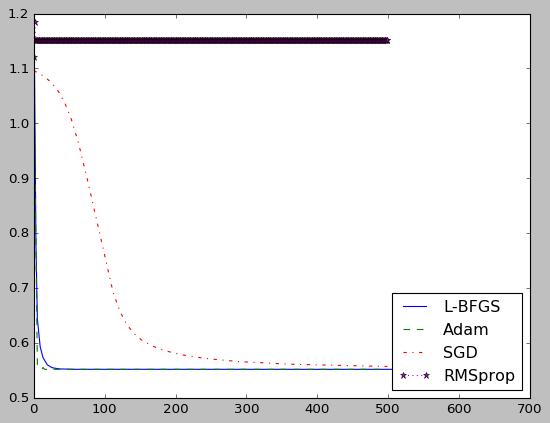

In [435]:
plt.plot(loss_lbfgs, 'b-', label="L-BFGS")
plt.plot(loss_adam, 'g--', label="Adam")
plt.plot(loss_sgd, 'r-.', label="SGD")
plt.plot(loss_rmsprop, 'm:*', label="RMSprop")
plt.legend(loc="lower right")
plt.style.use('fast')

In [0]:
with torch.no_grad():
  pred = model(torch.from_numpy(wine.data).float())
  l = lf(pred, torch.from_numpy(wine.target).long())
  
l

In [437]:
print optim.state_dict
print optim_adam.state_dict
print optim_sgd.state_dict
print optim_rmsprop.state_dict

<bound method LBFGS.state_dict of LBFGS (
Parameter Group 0
    history_size: 100
    line_search_fn: None
    lr: 0.1
    max_eval: 25
    max_iter: 20
    tolerance_change: 1e-09
    tolerance_grad: 1e-05
)>
<bound method Adam.state_dict of Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.1
    weight_decay: 0
)>
<bound method SGD.state_dict of SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0
    nesterov: False
    weight_decay: 0
)>
<bound method RMSprop.state_dict of RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.1
    momentum: 0
    weight_decay: 0
)>
